# Visual Verification: FID Loader and Processing Pipeline

**Goal:** Visually verify the strict 1D-to-ND Bruker memory reshaping, physical coordinate calculation, and the newly refactored `xmris` processing pipeline. We will explicitly use `xarray`'s native plotting to ensure units and axis names are automatically and correctly resolved.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# High-res output for crisp visual inspection
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
plt.rcParams["figure.dpi"] = 150

In [2]:
from pathlib import Path
import xarray as xr

from xmris.vendor.bruker import reshape_bruker_raw, build_fid
from xmris.core.config import DIMS, COORDS

# Configuration
xr.set_options(display_expand_data=False)


## 1. Data Loading

In [19]:
DATA_DIR = Path("../../../tests/data/")
FILE_PATH = Path(DATA_DIR / "nspect_slab_1H" / "rawdatajob0.nc")

In [25]:
raw_1d_data = xr.load_dataarray(FILE_PATH).xmr.to_complex()
raw_1d_data

<xarray.DataArray (raw: 10240)> Size: 164kB
(-1+0j) (-357-154j) (80+57j) ... (-858193-2706886j) (-920525-2714734j)
Dimensions without coordinates: raw
Attributes:
    PVM_SpecSWH:         5000
    PVM_RepetitionTime:  1000
    PVM_FrqRef:          127.6261421047187
    PVM_FrqWorkPpm:      4.7
    PVM_SpecMatrix:      2048
    PVM_EncNReceivers:   1
    PVM_NAverages:       5
    PVM_NRepetitions:    1
    groupDelay:          76.125

In [26]:
raw_1d_data.attrs

{'PVM_SpecSWH': 5000,
 'PVM_RepetitionTime': 1000,
 'PVM_FrqRef': 127.6261421047187,
 'PVM_FrqWorkPpm': 4.7,
 'PVM_SpecMatrix': 2048,
 'PVM_EncNReceivers': 1,
 'PVM_NAverages': 5,
 'PVM_NRepetitions': 1,
 'groupDelay': 76.125}

In [27]:
# 2. Reshape into C-contiguous N-dimensional numpy array
reshaped_nd, valid_dims = reshape_bruker_raw(raw_1d_data.values, raw_1d_data.attrs)

Reshaped Bruker data to dims: [ time | averages ]


In [28]:
fid_xr = build_fid(reshaped_nd, valid_dims, raw_1d_data.attrs)

print(f"Constructed FID Shape: {fid_xr.shape}")
print(f"Assigned Attributes: {list(fid_xr.attrs.keys())}")

Constructed FID Shape: (2048, 5)
Assigned Attributes: ['reference_frequency', 'carrier_ppm', 'bruker_group_delay', 'units']


## 2. Apply the `xmris` Pipeline

Transform the time-domain FID into the frequency domain along the `time` dimension, and convert the relative `frequency` coordinates to absolute `chemical_shift` using the Bouncer-enforced metadata.

In [29]:
# Select the first repetition/channel/average for basic visual inspection if multi-dimensional
if fid_xr.ndim > 1:
    fid_inspect = fid_xr.isel({d: 0 for d in fid_xr.dims if d != DIMS.time})
else:
    fid_inspect = fid_xr

fid_inspect

<xarray.DataArray 'data' (time: 2048)> Size: 33kB
(-1+0j) (-357-154j) (80+57j) ... (-9501091-10503302j) (-9528947-10457342j)
Coordinates:
  * time      (time) float64 16kB 0.0 0.0002 0.0004 ... 0.409 0.4092 0.4094
    averages  int64 8B 0
Attributes:
    reference_frequency:  127.6261421047187
    carrier_ppm:          4.7
    bruker_group_delay:   76.125
    units:                a.u.

## 3. Visualizing the Time Domain (FID)

Verify signal decay shape, complex quadrature, and absence of truncation artifacts. By using `xarray.plot()`, the x-axis should automatically read "Time [s]".

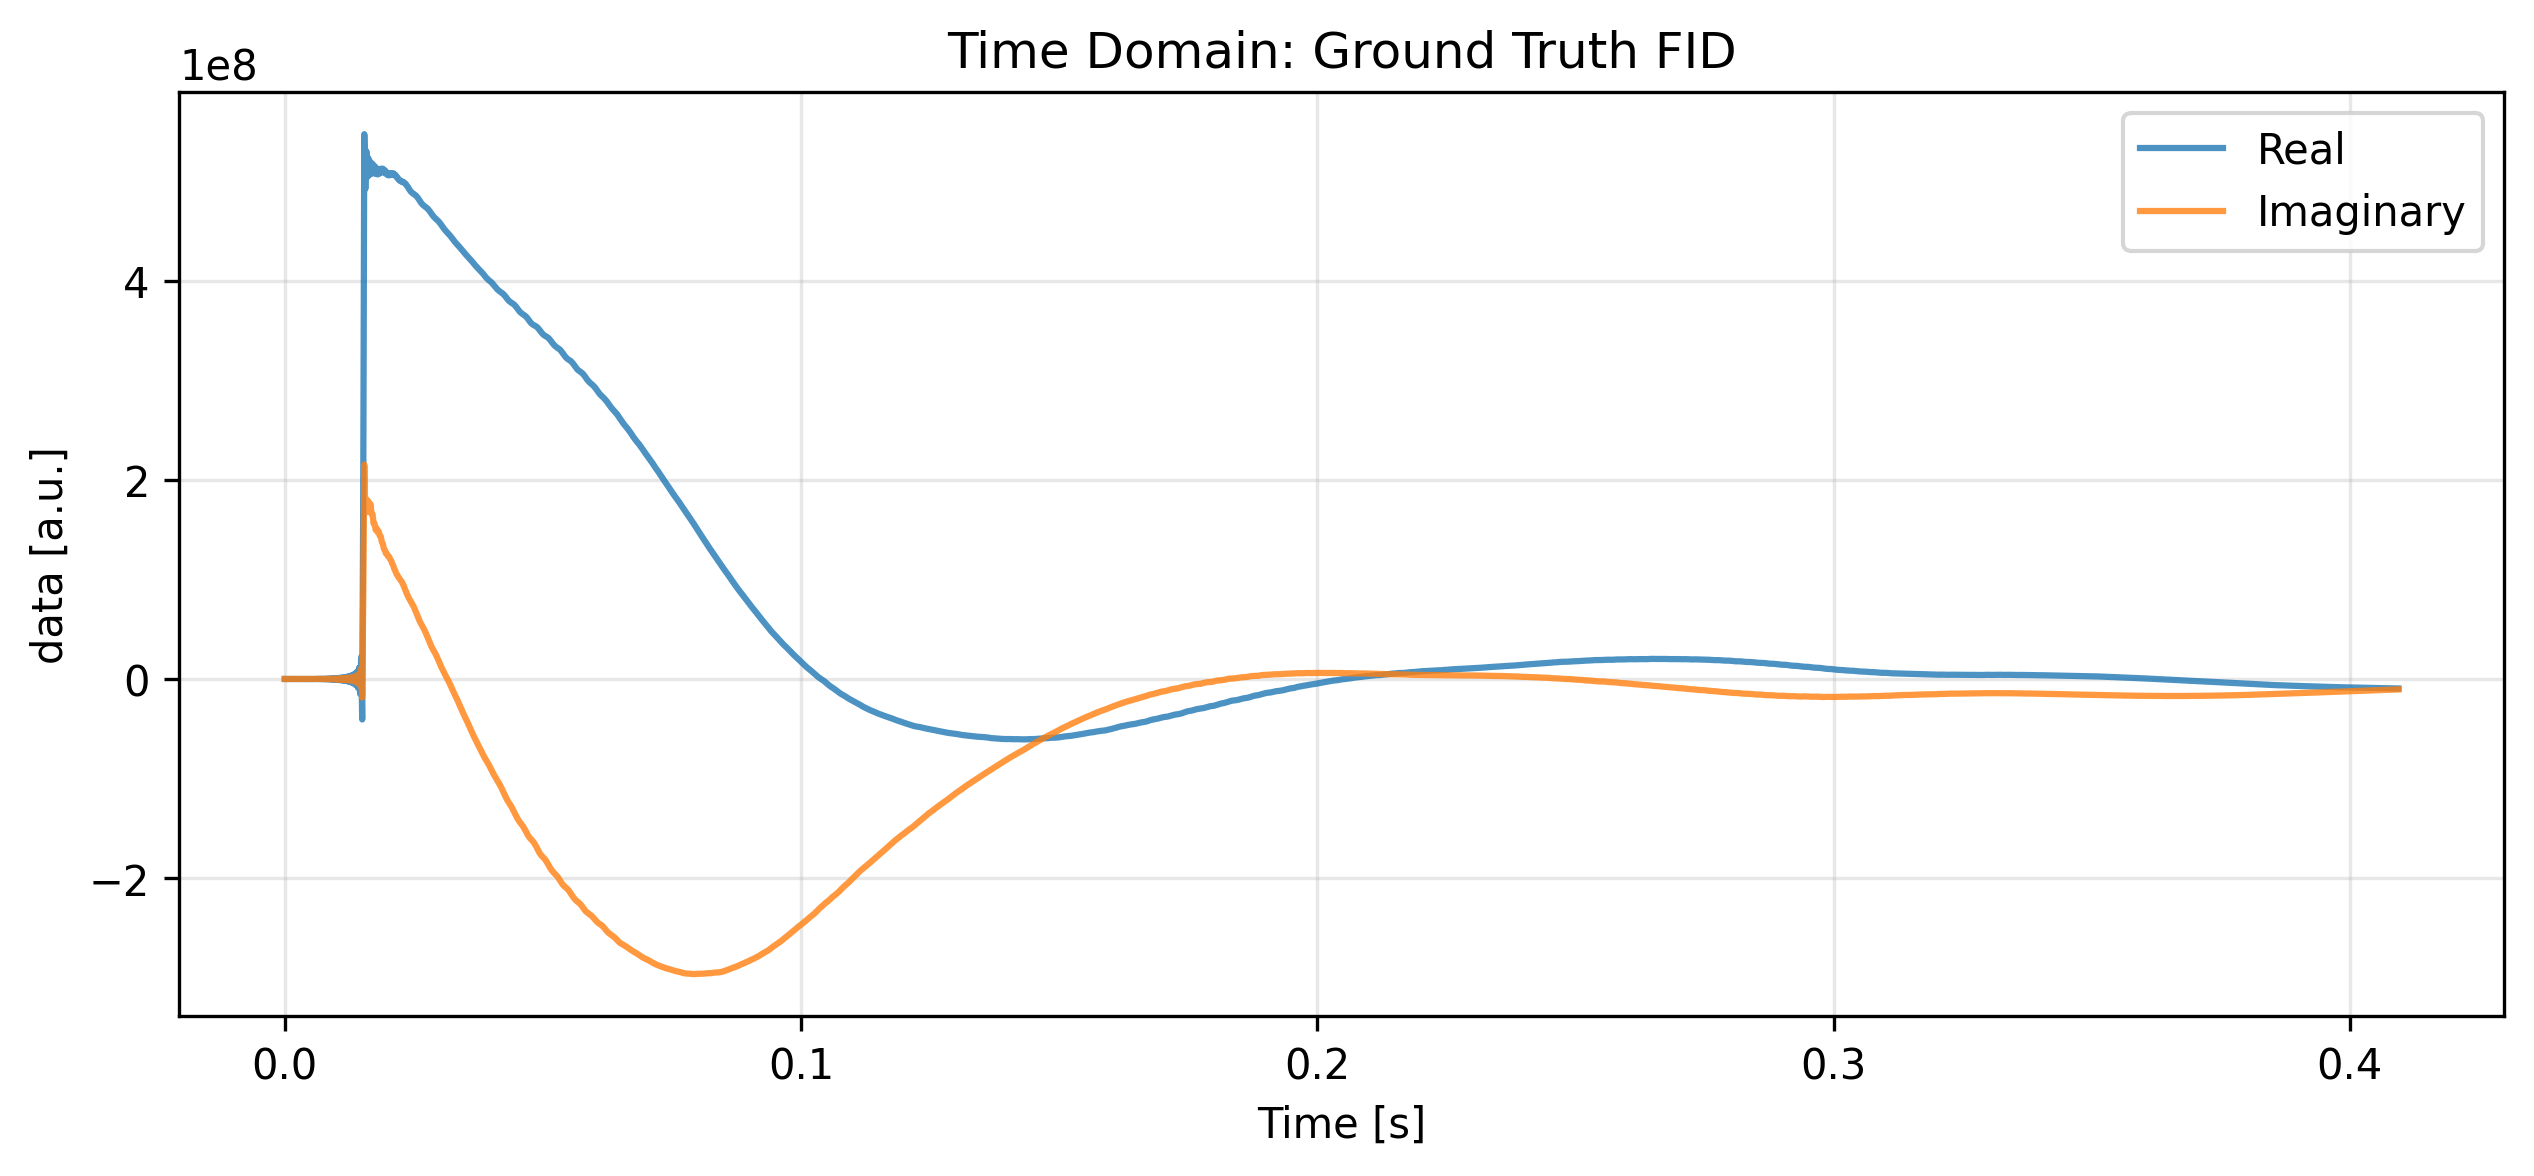

In [30]:
fig, ax = plt.subplots(figsize=(10, 4))

# Use xarray's native plotting to verify automatic labels
fid_inspect.real.plot(ax=ax, label="Real", alpha=0.8)
fid_inspect.imag.plot(ax=ax, label="Imaginary", alpha=0.8)

ax.set_title("Time Domain: Ground Truth FID")
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

In [37]:
fid_corrected = fid_inspect.xmr.remove_digital_filter(group_delay=raw_1d_data.attrs["groupDelay"], keep_length=False)

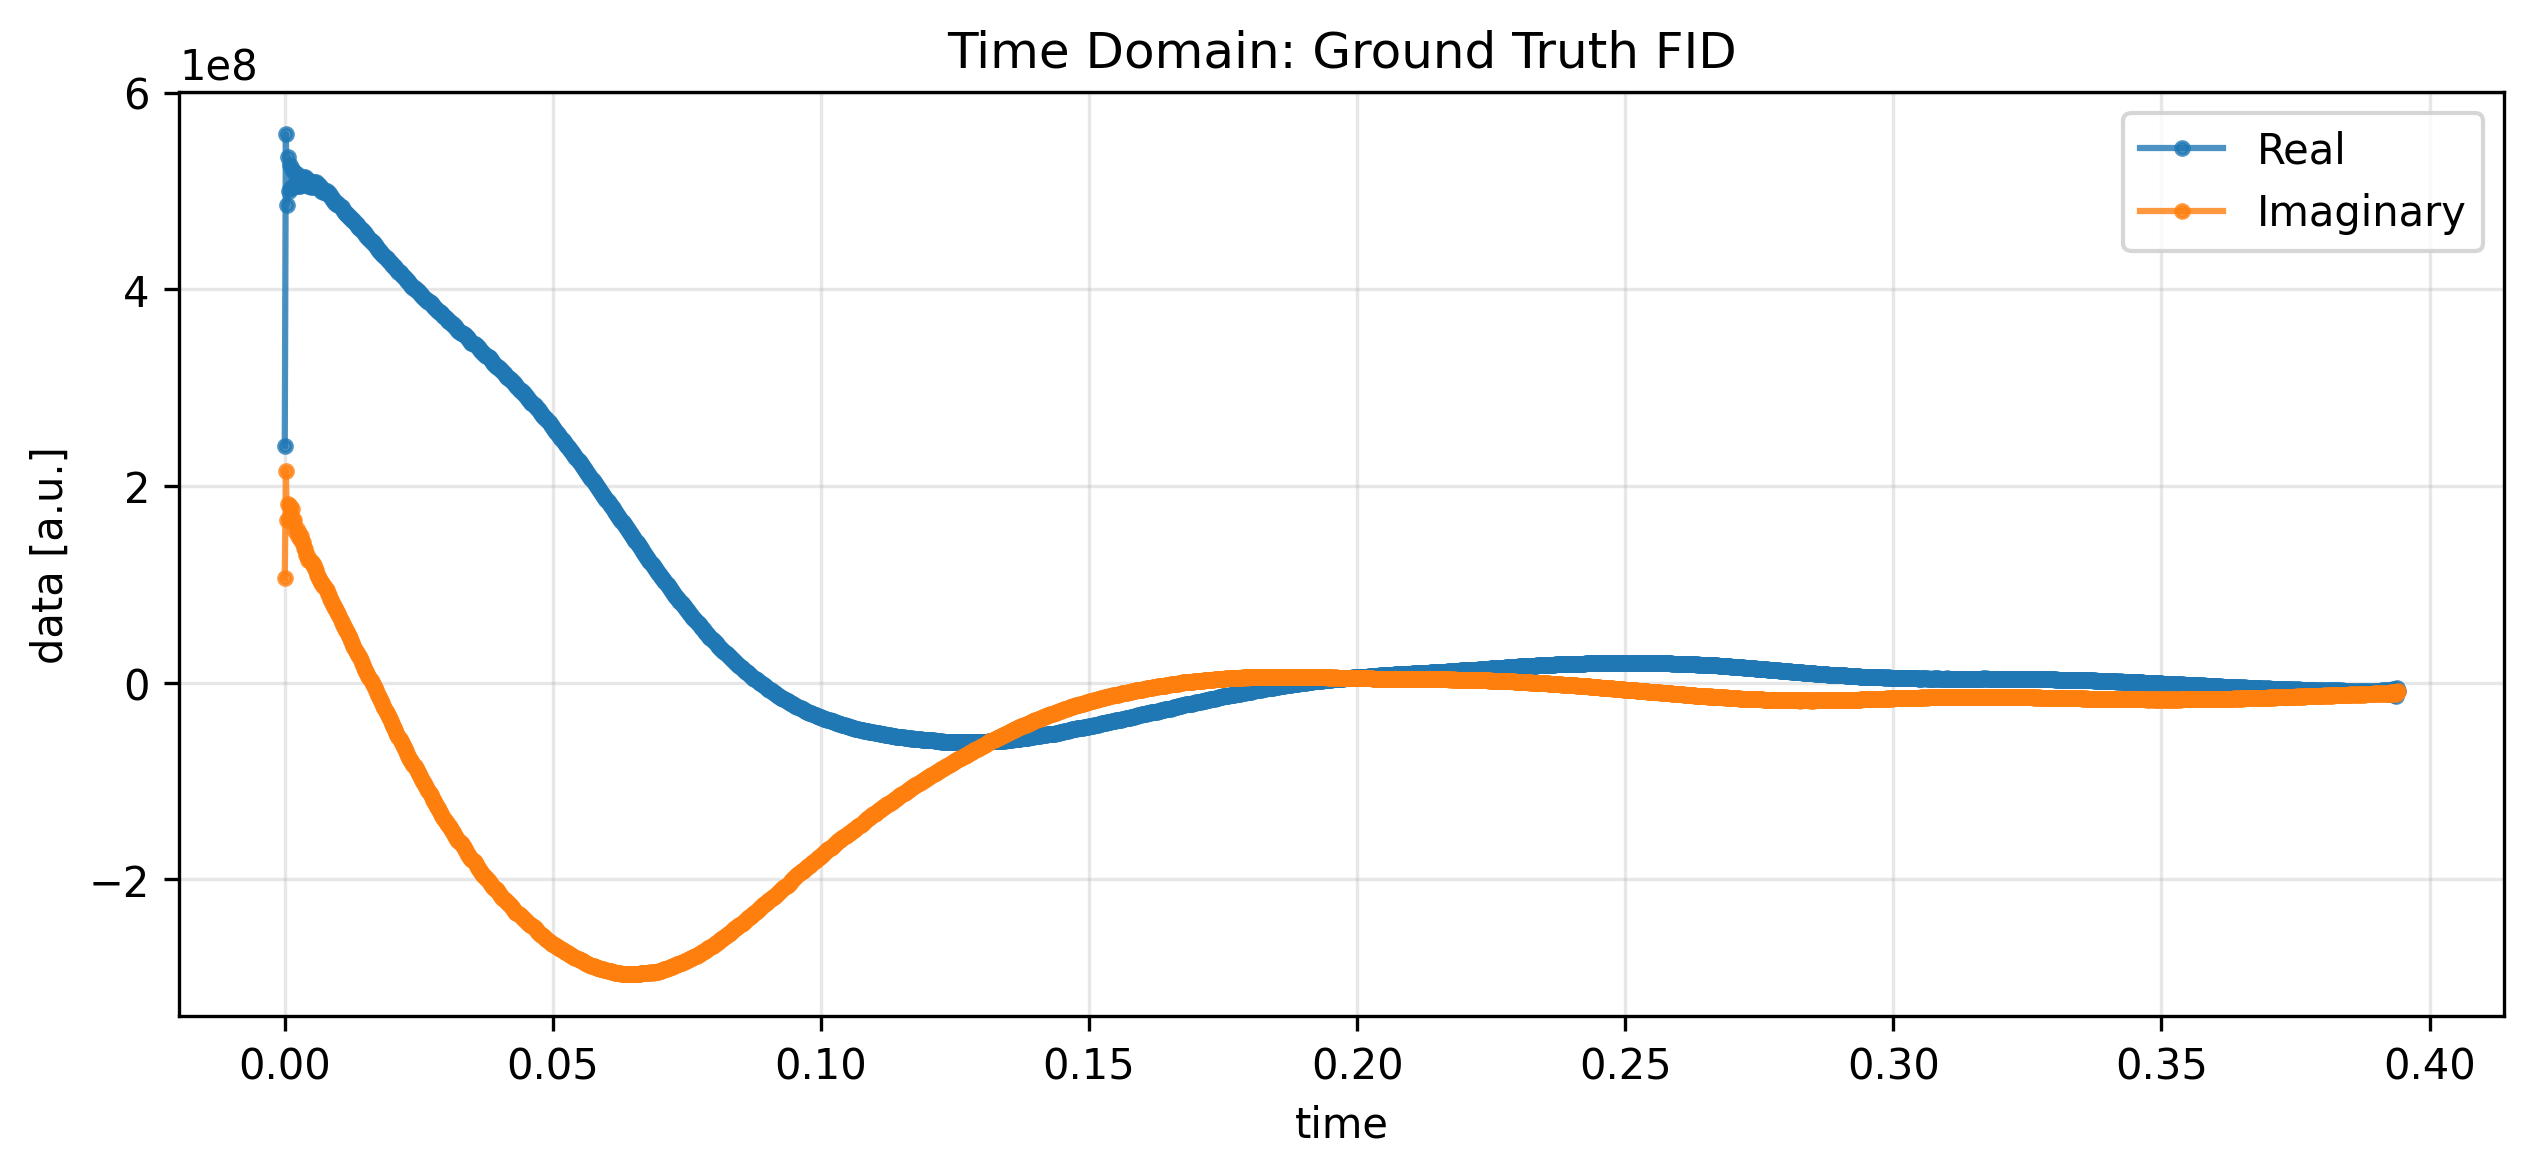

In [38]:
fig, ax = plt.subplots(figsize=(10, 4))

# Use xarray's native plotting to verify automatic labels
fid_corrected.real.plot(ax=ax, label="Real", alpha=0.8, marker='.')
fid_corrected.imag.plot(ax=ax, label="Imaginary", alpha=0.8, marker='.')

ax.set_title("Time Domain: Ground Truth FID")
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()

In [40]:
spectrum = fid_corrected.xmr.to_spectrum().xmr.autophase().xmr.autophase()

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 173
         Function evaluations: 320
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 55
         Function evaluations: 110


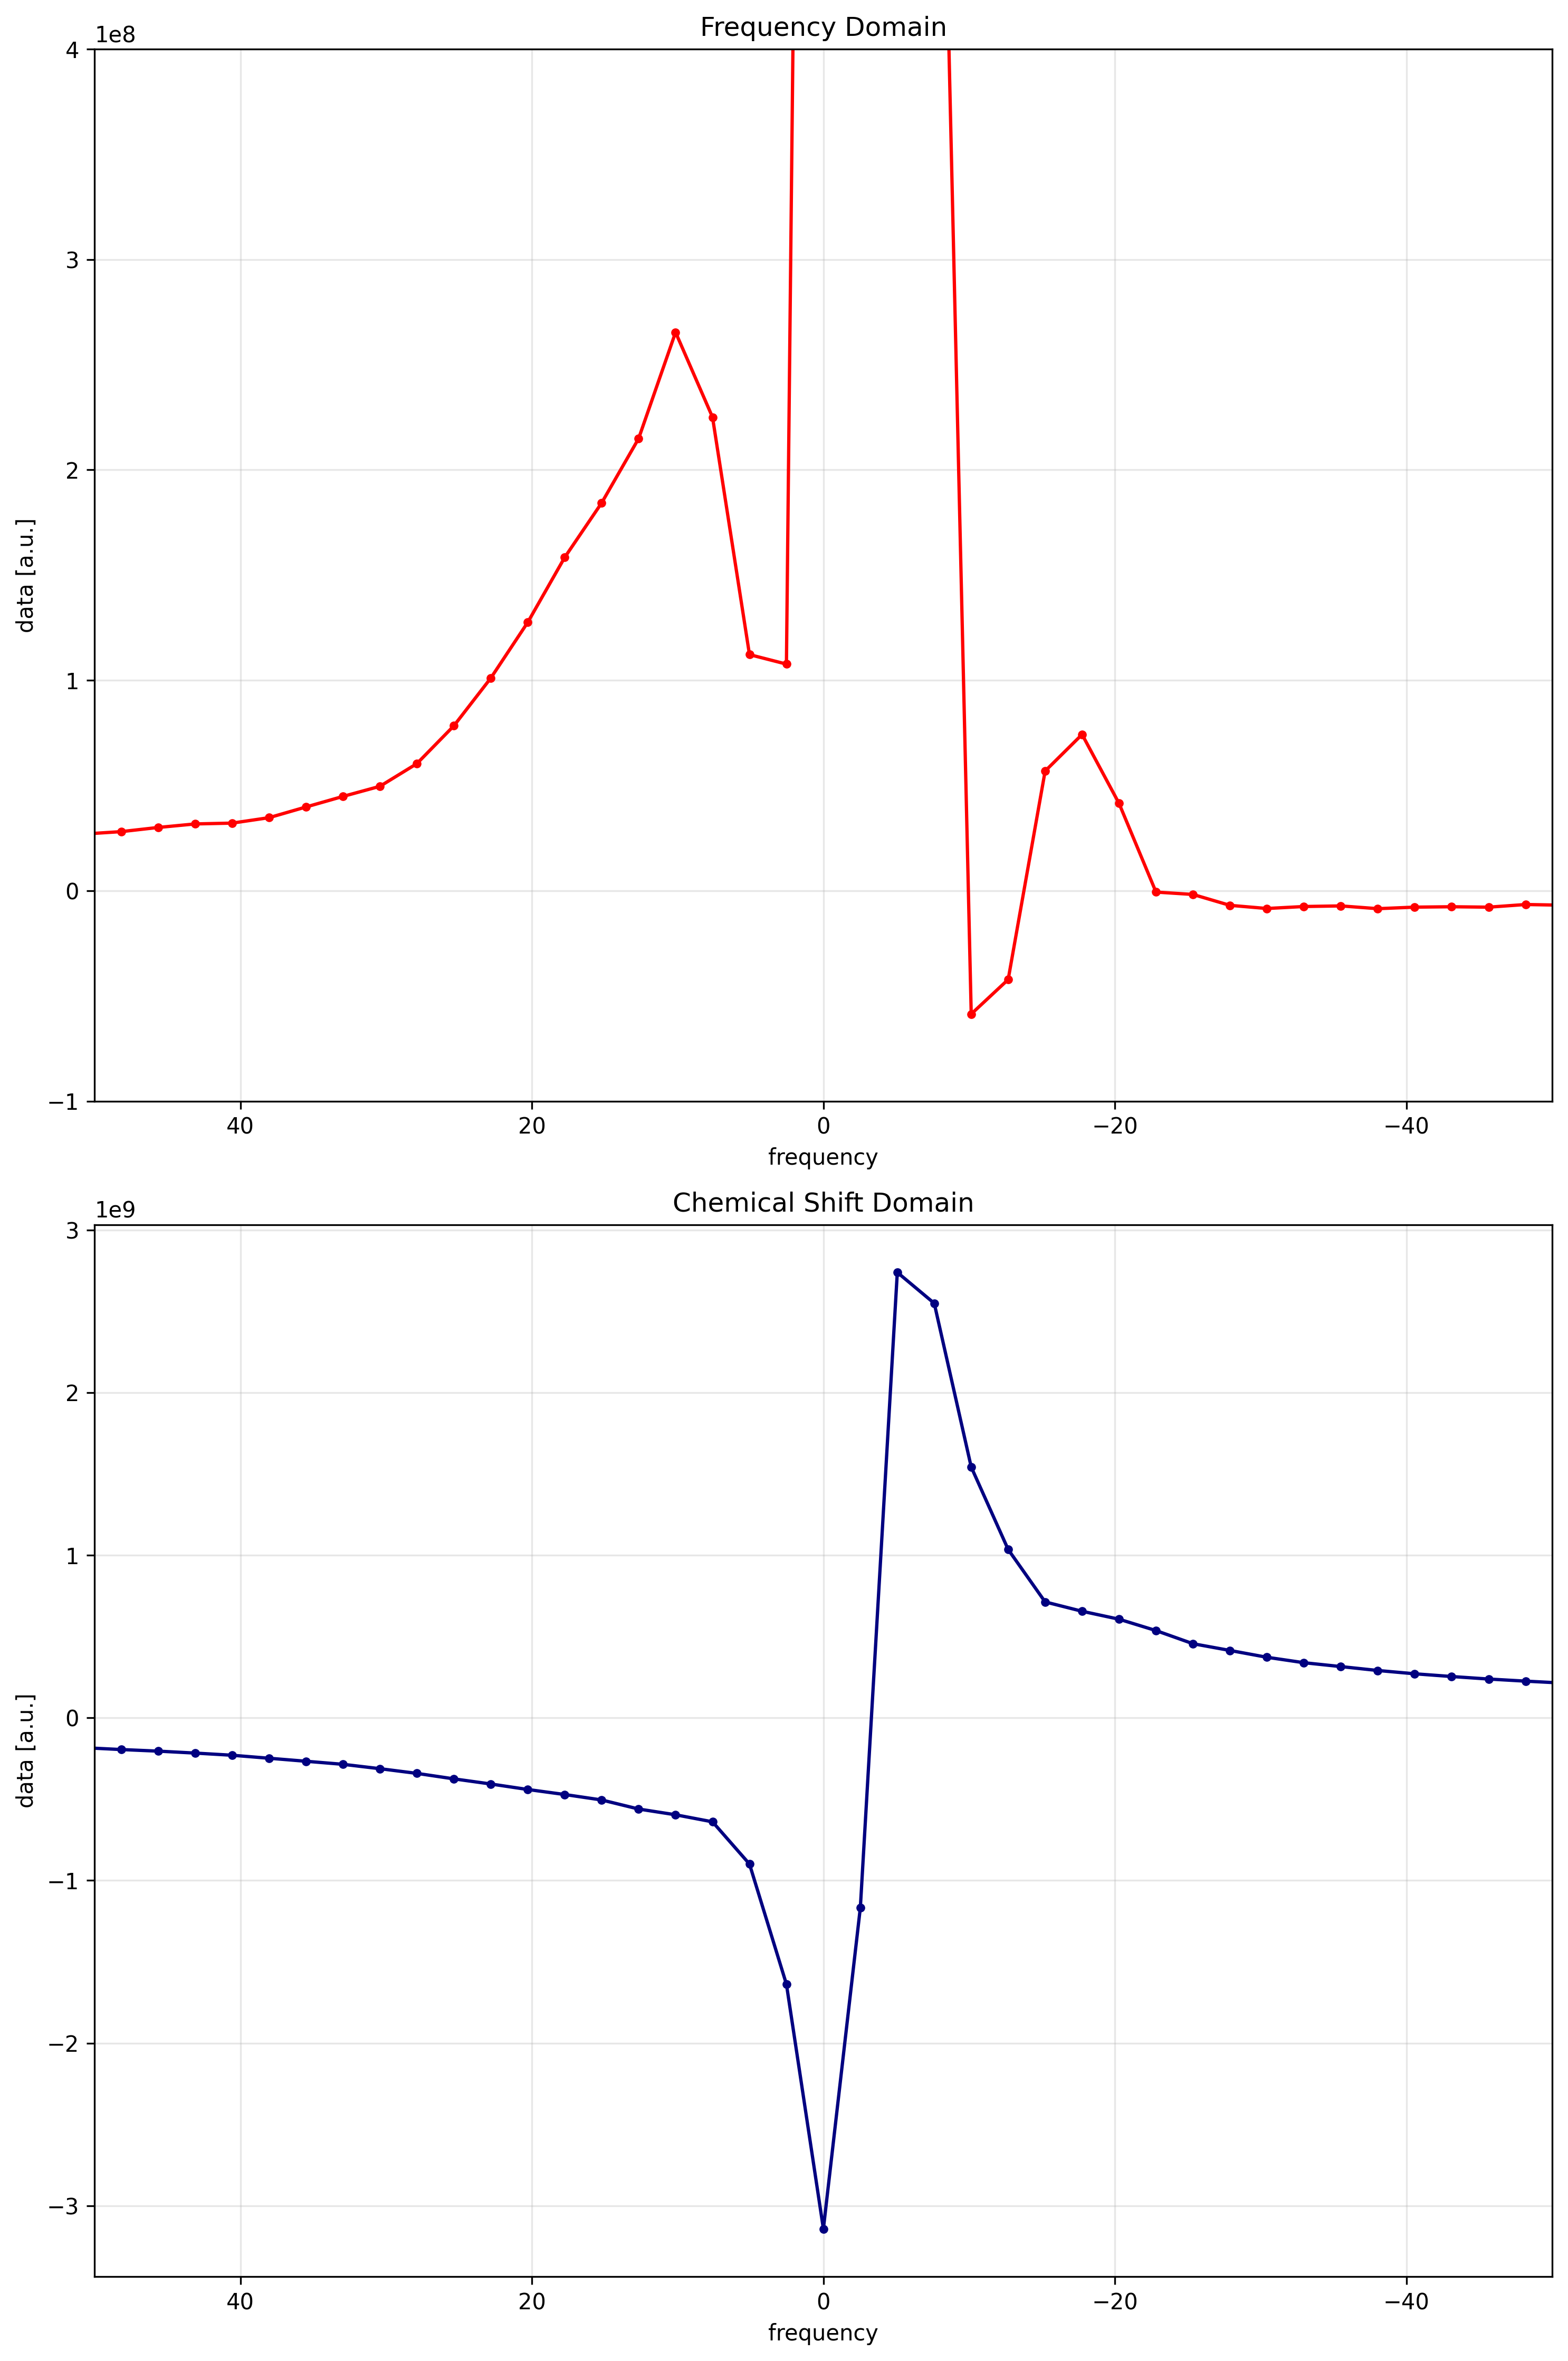

In [41]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 15))

# --- Subplot 1: Frequency (Hz) ---
spectrum.real.plot(ax=ax1, color="red", marker='.')
# spectrum.imag.plot(x=DIMS.frequency, ax=ax1, color="blue")
ax1.set_title("Frequency Domain")
ax1.grid(True, alpha=0.3)
ax1.set_xlim(-50, 50)
ax1.set_ylim(-1e8, 4e8)
ax1.xaxis.set_inverted(True)
# --- Subplot 2: ---
spectrum.imag.plot(ax=ax2, color="navy", marker='.')
ax2.set_title("Chemical Shift Domain")
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-50, 50)
# ax2.set_ylim(-1e8, 4e8)
ax2.xaxis.set_inverted(True)

plt.tight_layout()
plt.show()

In [42]:
# Apply the strict xmris pipeline
spectrum = (
    fid_corrected
    .xmr.apodize_exp(lb=30)
    .xmr.to_spectrum()
    .xmr.autophase()
)

# Apply the strict xmris pipeline
# spectrum = (
#     fid_inspect
#     .xmr.to_spectrum()
#     .xmr.phase(p1=-p.acqp["ACQ_RxFilterInfo"][0][0] * 360)
# )

spectrum

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 115
         Function evaluations: 218


<xarray.DataArray (frequency: 1972)> Size: 32kB
(700288.680992511+5499999.330530477j) ... (1418600.8981560501-5353241.5293068...
Coordinates:
    averages   int64 8B 0
  * frequency  (frequency) float64 16kB -2.5e+03 -2.497e+03 ... 2.497e+03
Attributes:
    reference_frequency:         127.6261421047187
    carrier_ppm:                 4.7
    bruker_group_delay:          76.125
    units:                       a.u.
    digital_filter_removed:      True
    group_delay_removed:         76.125
    length_retained_with_zeros:  False
    p0:                          -119.13524101202837
    p1:                          200.15400855326521

## 4. Visualizing the Frequency Domain (Spectrum)

Verify that the Fourier transform executed correctly. By passing the explicit x-coordinate to `xarray.plot()`, the axes should automatically label themselves "Frequency [Hz]" and "Chemical Shift [ppm]".

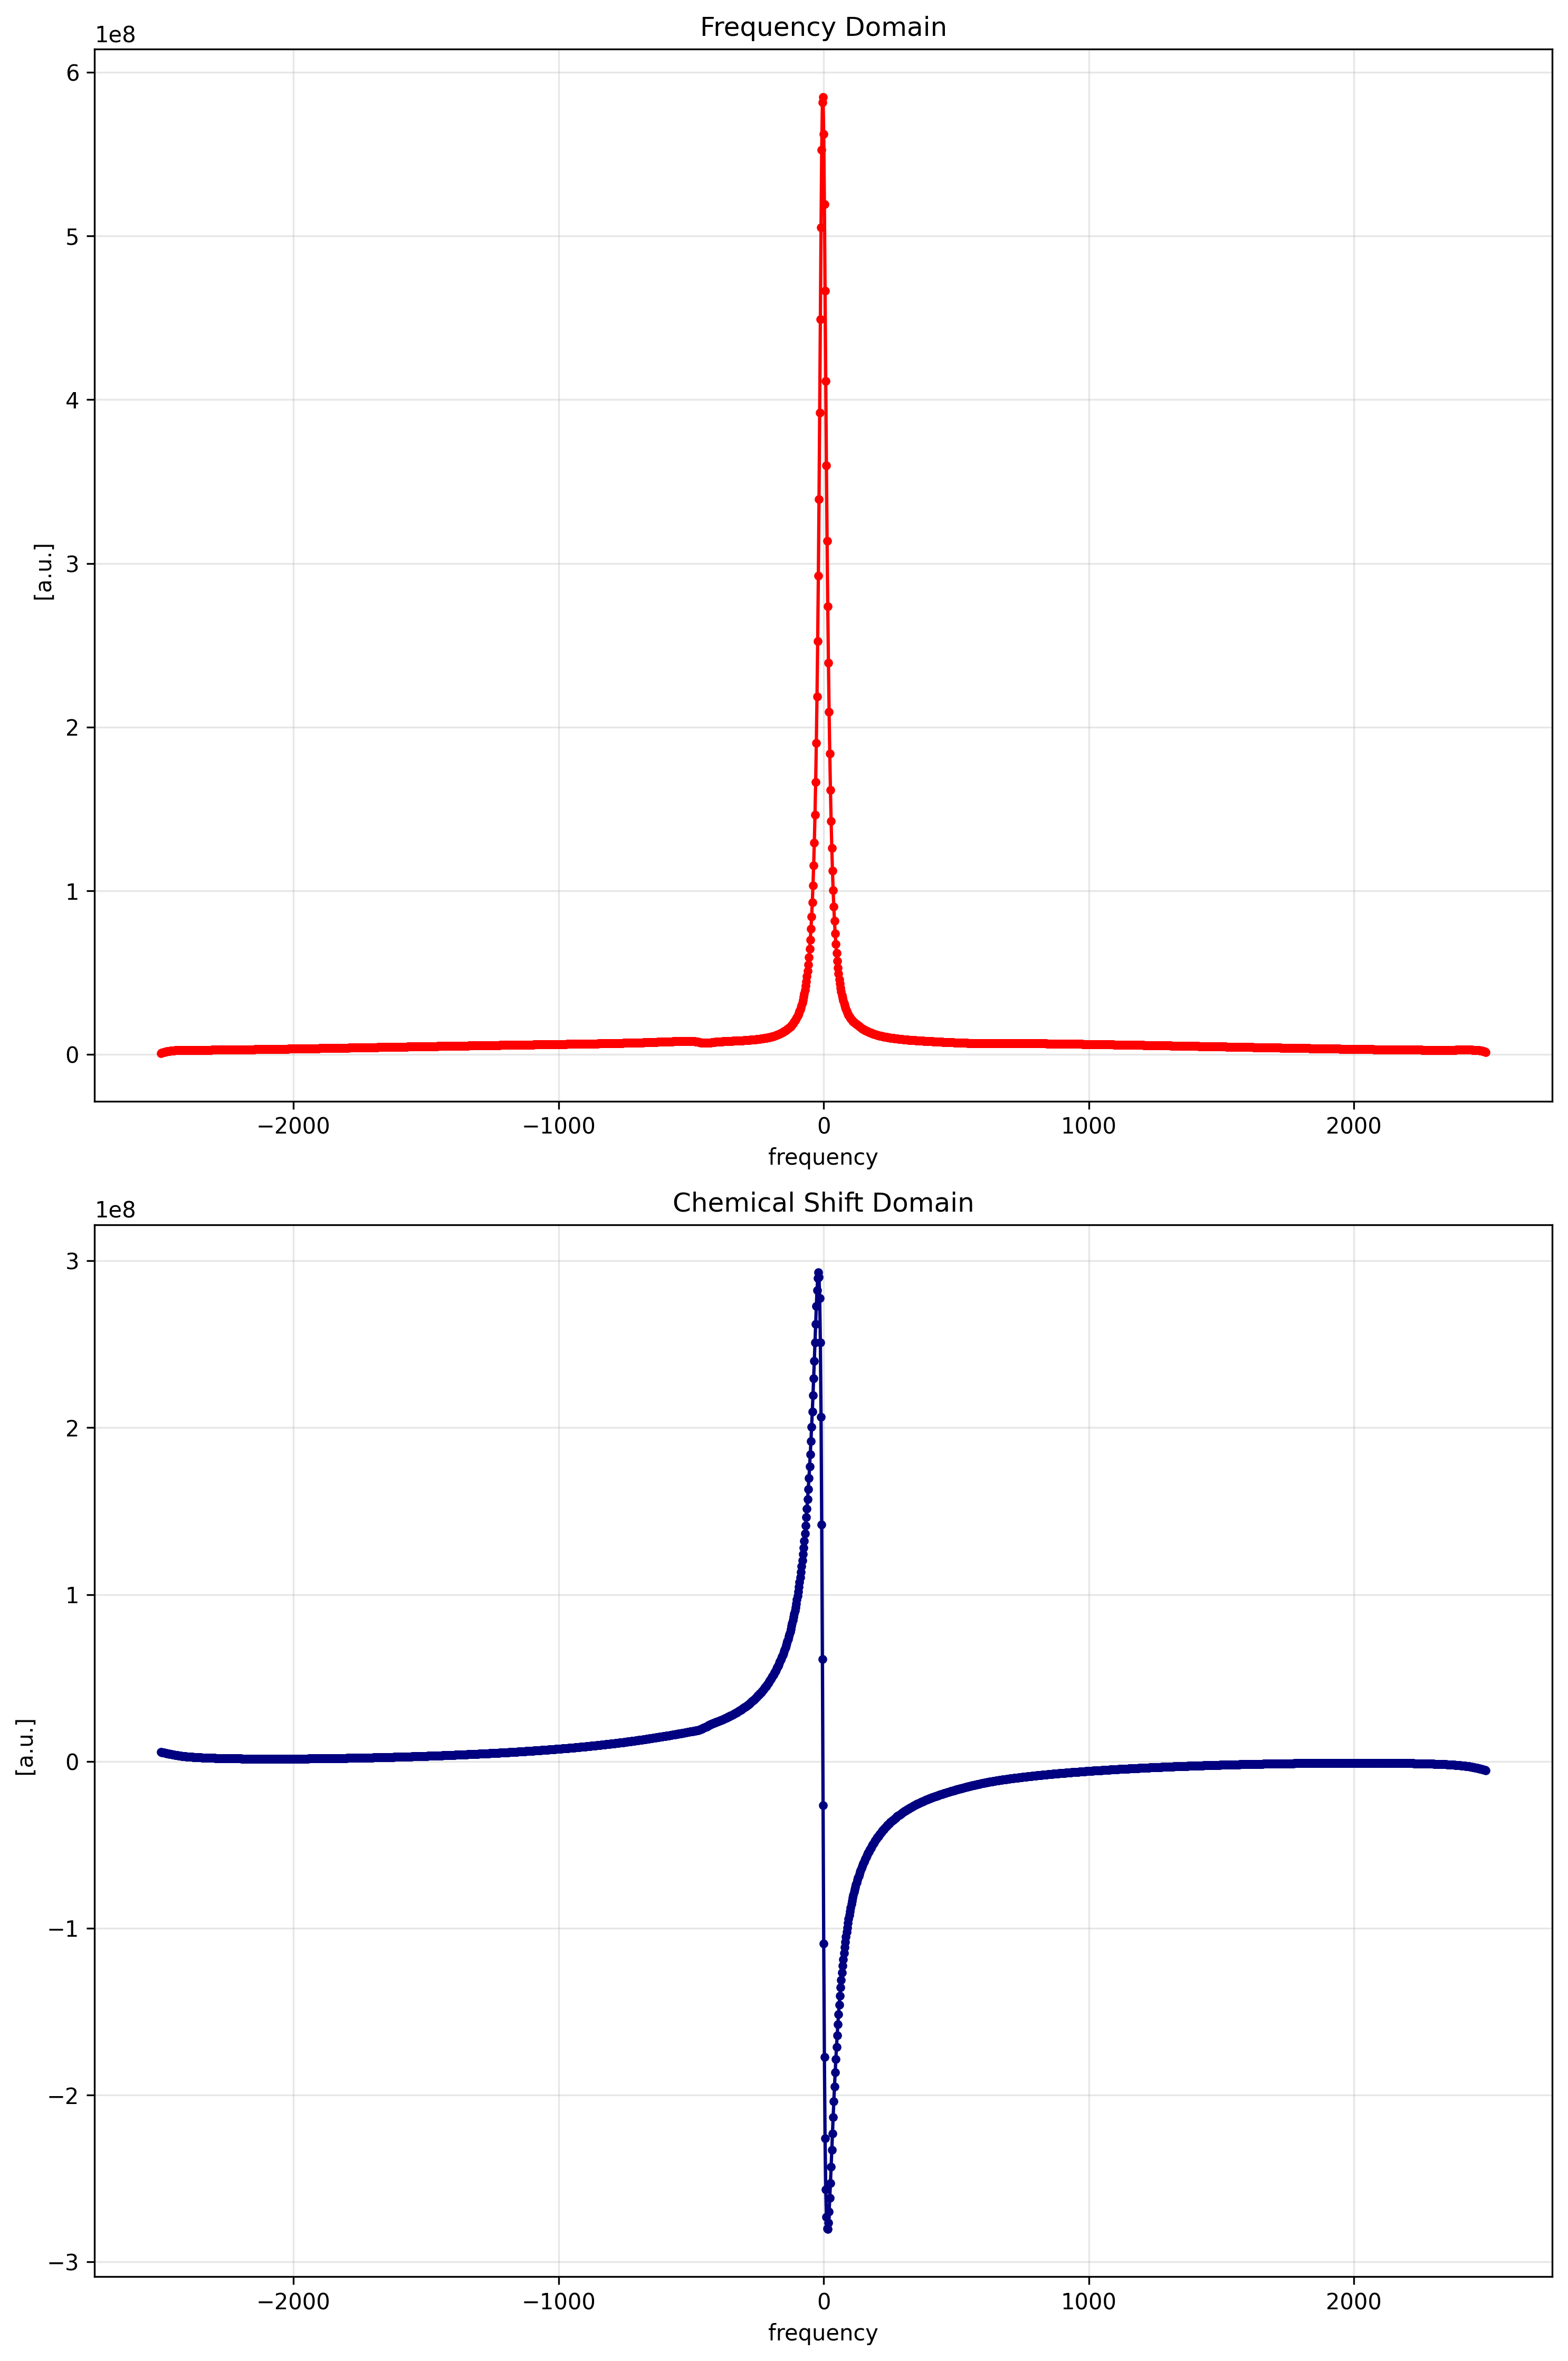

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 15))

# --- Subplot 1: Frequency (Hz) ---
spectrum.real.plot(ax=ax1, color="red", marker='.')
# spectrum.imag.plot(x=DIMS.frequency, ax=ax1, color="blue")
ax1.set_title("Frequency Domain")
ax1.grid(True, alpha=0.3)
# ax1.set_xlim(-200, 200)
# --- Subplot 2: ---
spectrum.imag.plot(ax=ax2, color="navy", marker='.')
ax2.set_title("Chemical Shift Domain")
ax2.grid(True, alpha=0.3)
# ax2.set_xlim(-200, 200)


plt.tight_layout()
plt.show()

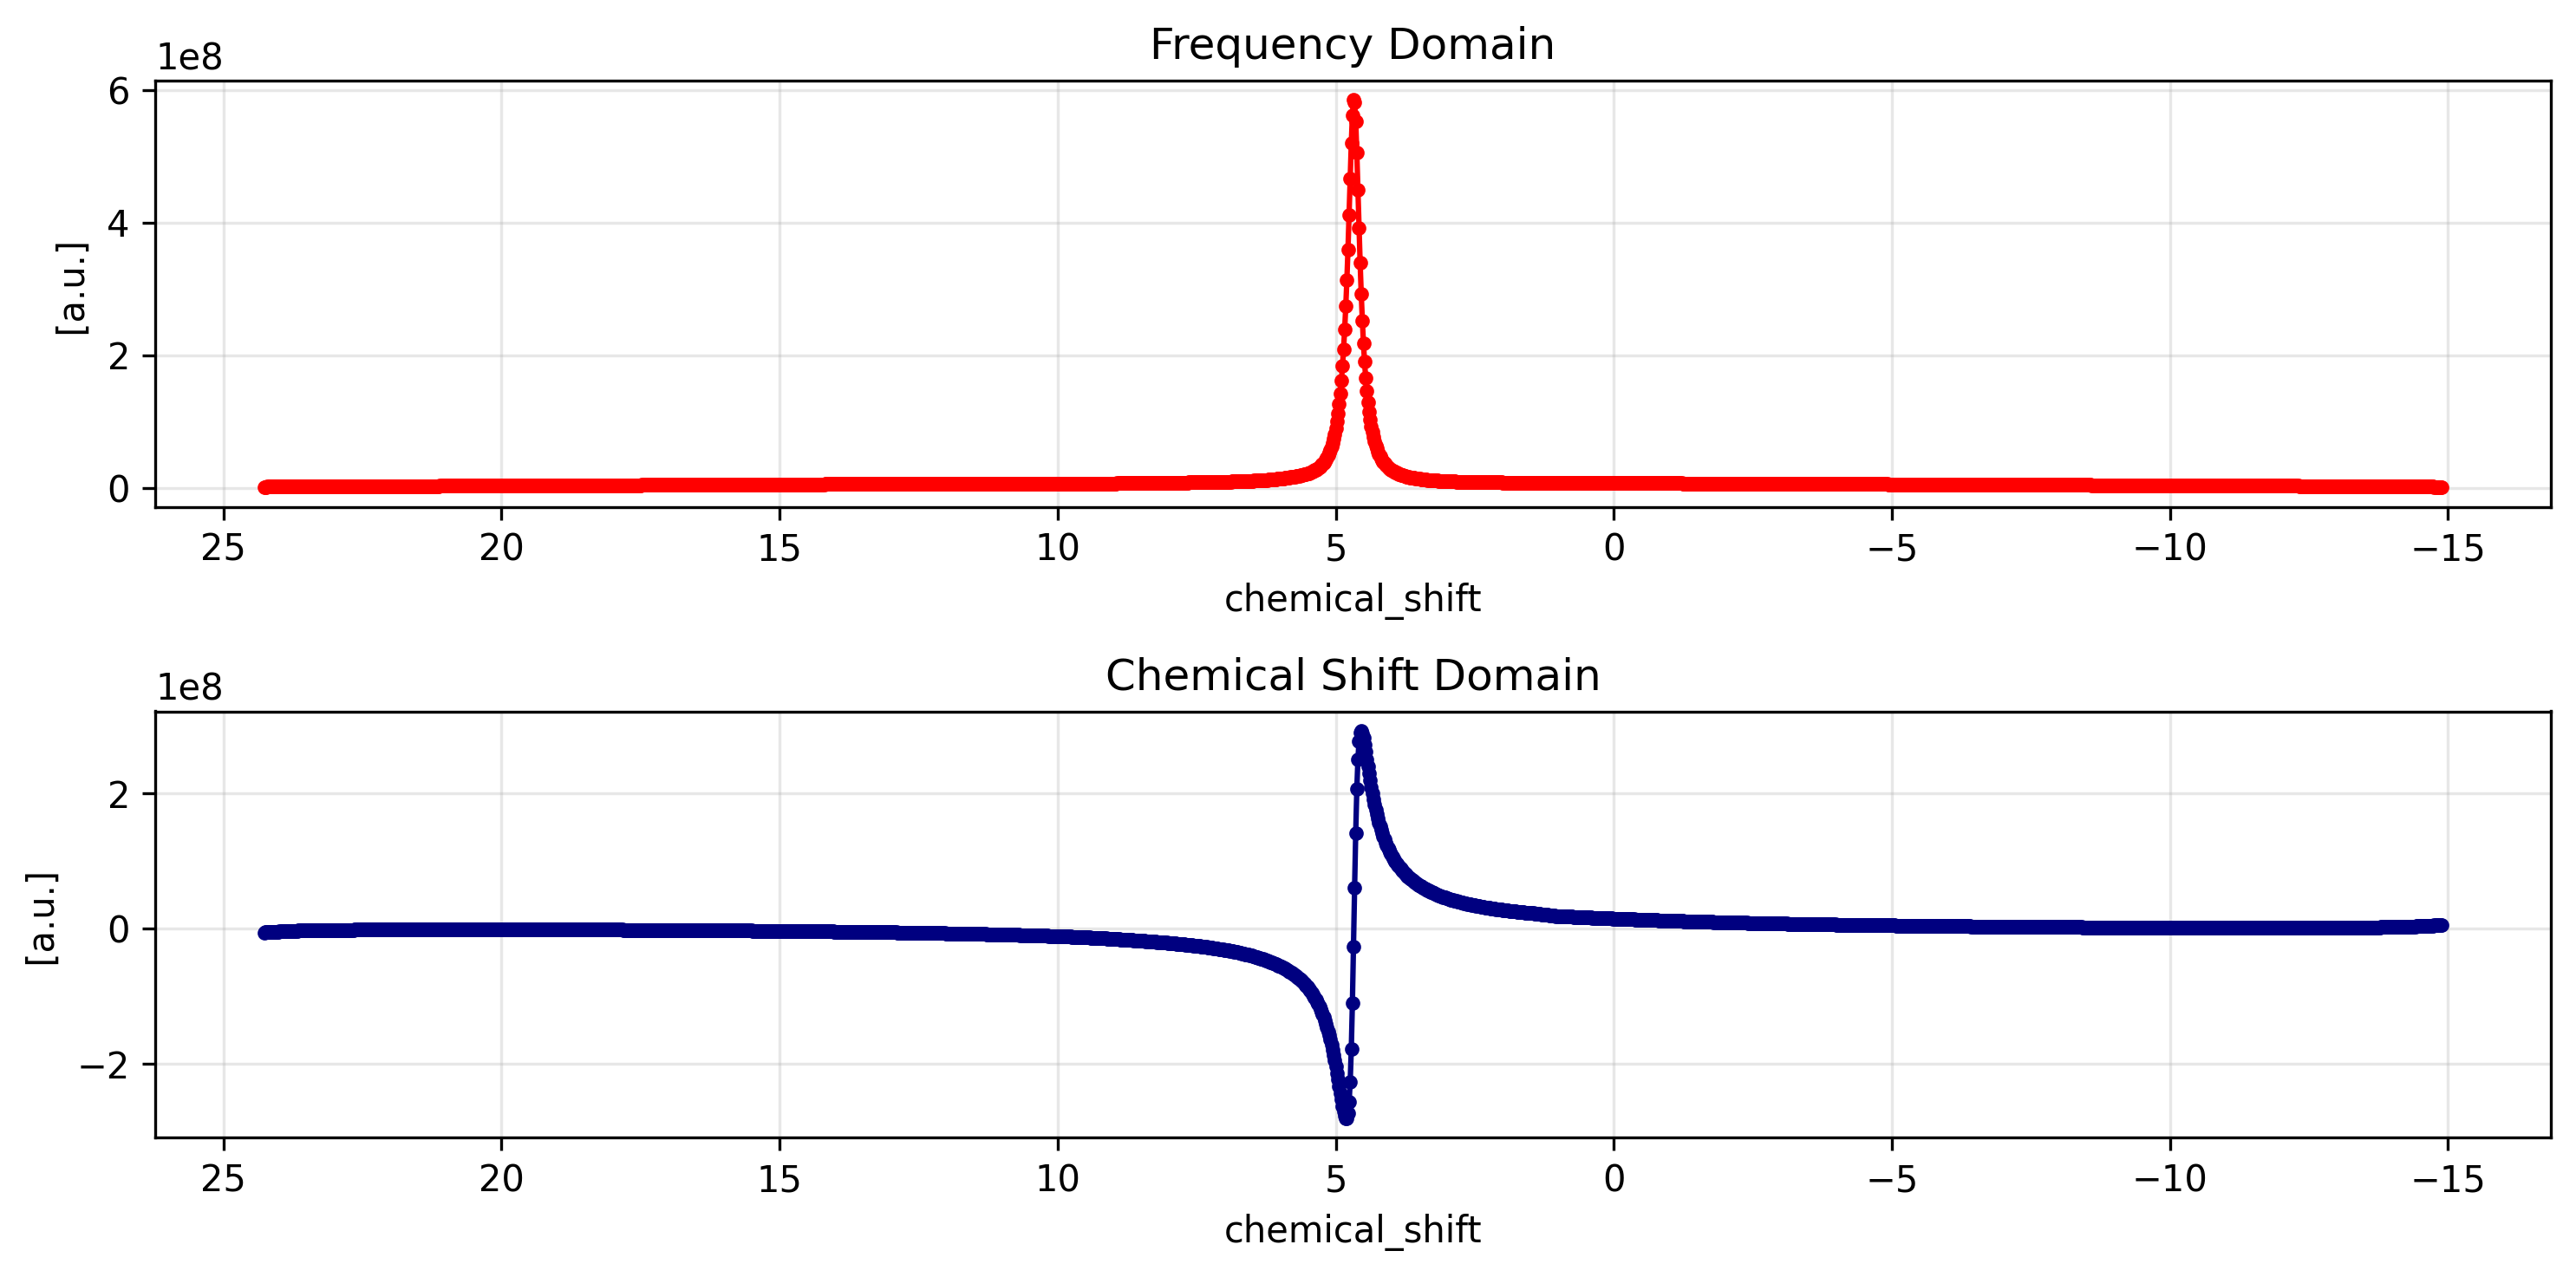

In [44]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5))

spectrum_ppm = spectrum.xmr.to_ppm()
# --- Subplot 1: Frequency (Hz) ---
spectrum_ppm.real.plot(ax=ax1, x='chemical_shift', color="red", marker='.')
# spectrum.imag.plot(x=DIMS.frequency, ax=ax1, color="blue")
ax1.set_title("Frequency Domain")
ax1.grid(True, alpha=0.3)
# ax1.set_xlim(3, 6.4)
ax1.xaxis.set_inverted(True)
# --- Subplot 2: ---
spectrum_ppm.imag.plot(ax=ax2, x='chemical_shift', color="navy", marker='.')
ax2.set_title("Chemical Shift Domain")
ax2.grid(True, alpha=0.3)
# ax2.set_xlim(3, 6.4)
ax2.xaxis.set_inverted(True)

plt.tight_layout()
plt.show()

In [45]:
fid_final = spectrum.xmr.to_fid()

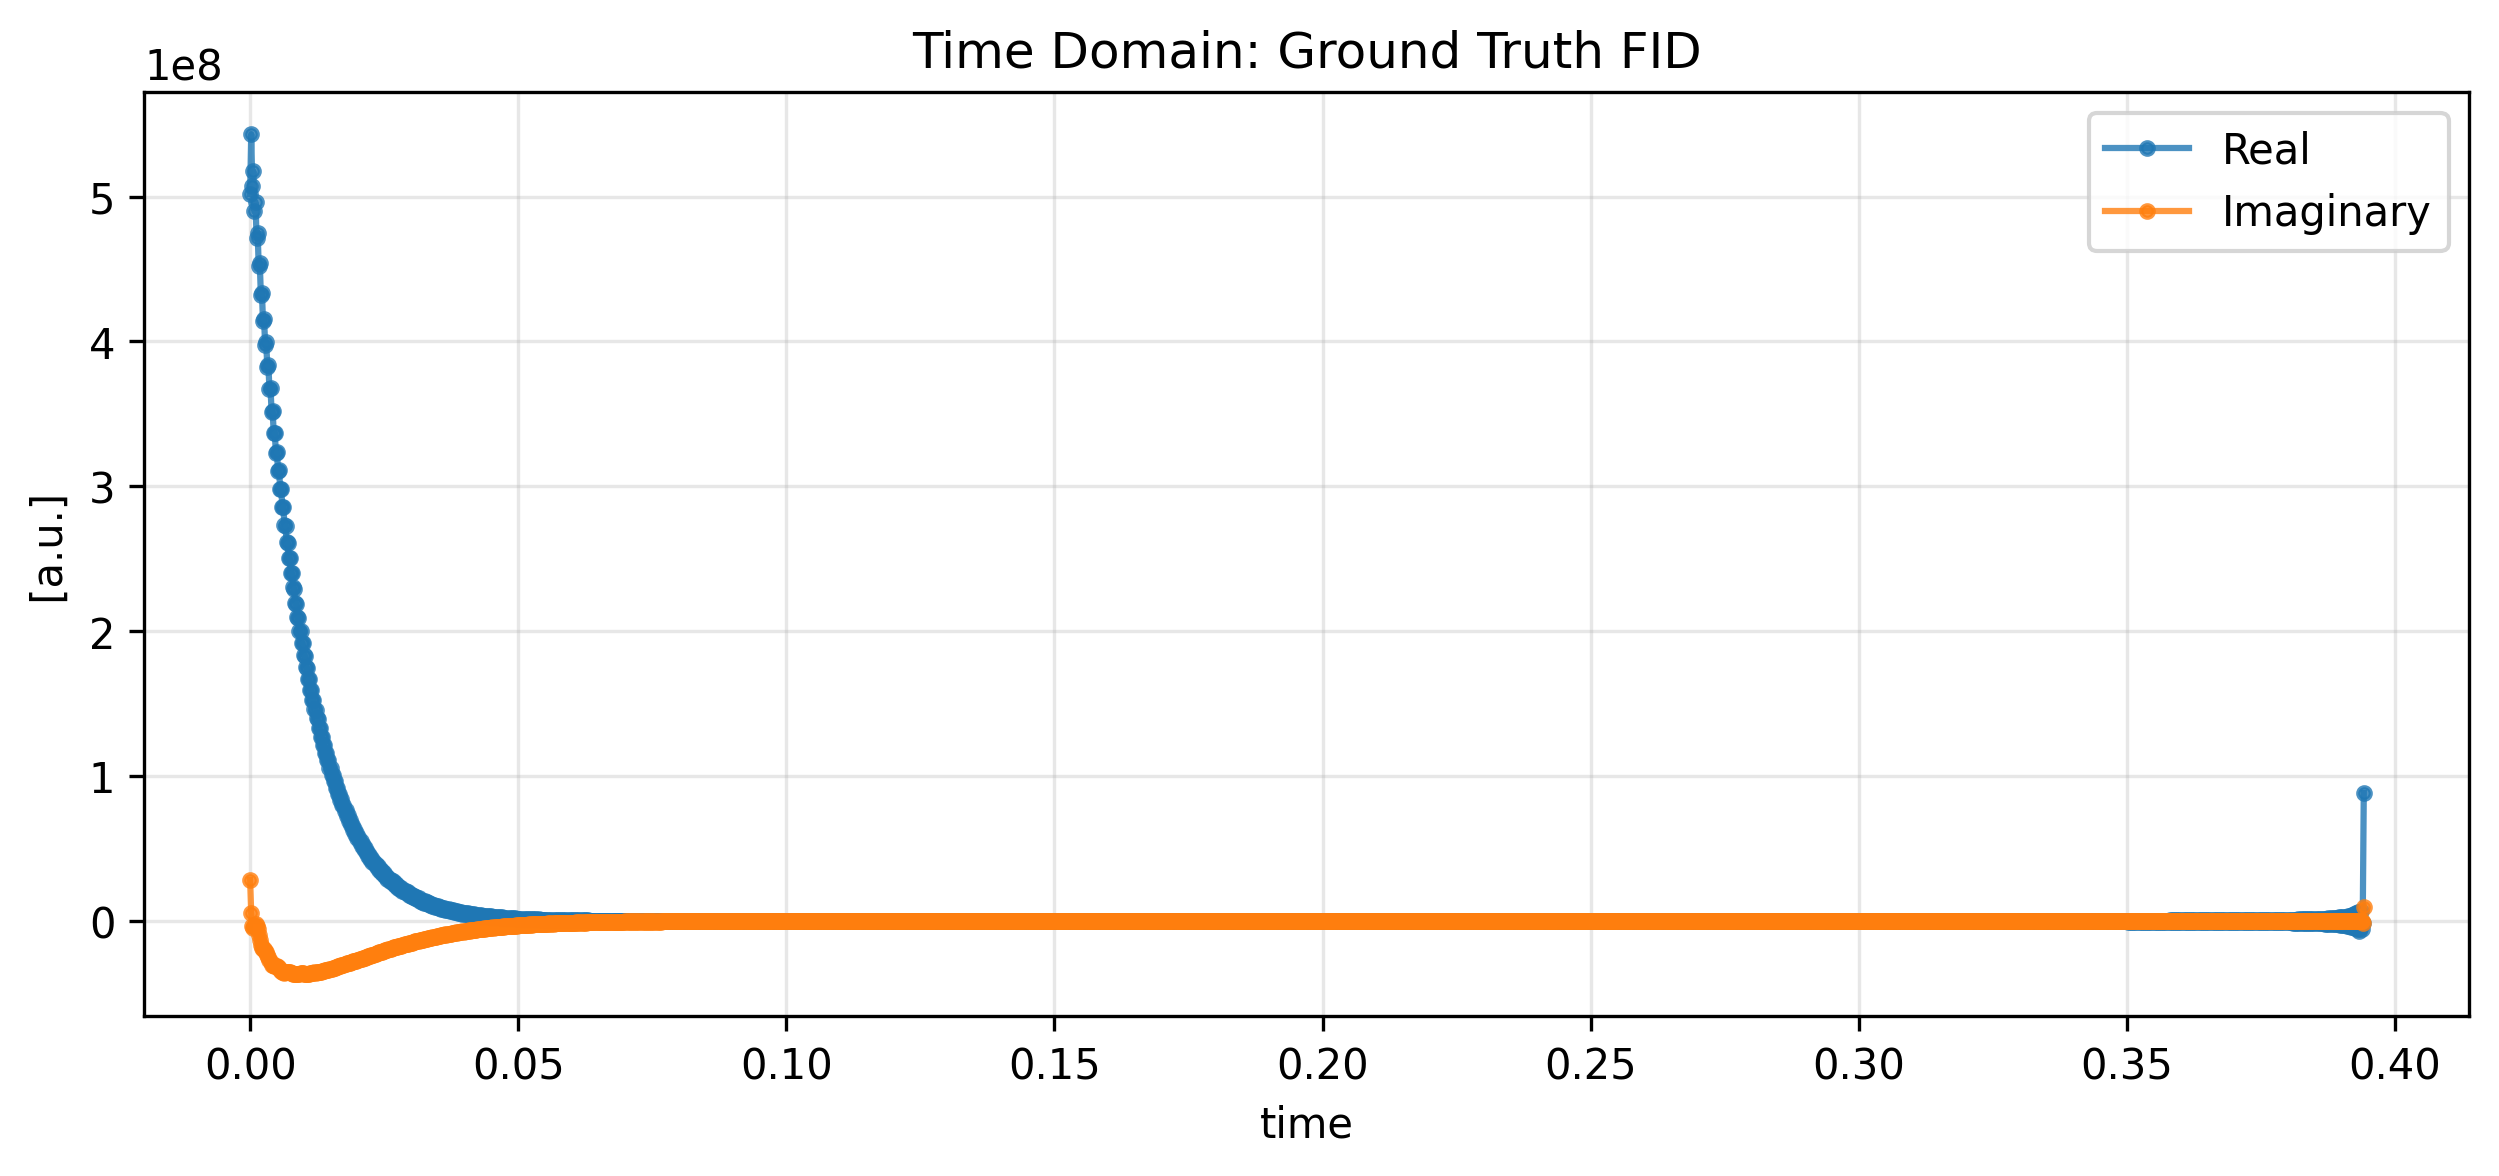

In [46]:
fig, ax = plt.subplots(figsize=(10, 4))

# Use xarray's native plotting to verify automatic labels
fid_final.real.plot(ax=ax, label="Real", alpha=0.8, marker='.')
fid_final.imag.plot(ax=ax, label="Imaginary", alpha=0.8, marker='.')

ax.set_title("Time Domain: Ground Truth FID")
ax.legend()
ax.grid(True, alpha=0.3)

plt.show()